# Modeling rolling band.

Rolling band is the primary instrumental false positive signal in the search for exoplanets in the Kepler mission.  The lightkurve documentation has a rolling band tutorial that explains how electronic image artifacts give rise to rolling band:

> certain CCD channels occasionally experience the 'rolling band' effect, where the background has a strong time varying component of a 'band' moving up the detector. You can read more about rolling band in the [Kepler Instrument Handbook](https://archive.stsci.edu/kepler/manuals/KSCI-19033-001.pdf). An example of the rolling band artifact is shown in the video below. You can see the band move through the superstamp at the 2 second mark, leaving the bottom of the screen at the 6 second mark.

![](img/rollingband.gif)

In this demo we explore the possibility of modeling rolling band with a non-stationary Gaussian process, with phase-shifted time axes.  This approach was inspired by cell 6 of the [deep kernel learning example](https://github.com/cornellius-gp/gpytorch/blob/master/examples/08_Deep_Kernel_Learning/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.ipynb) of GPyTorch.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

The animated gif above shows Galaxy IC 1613.  From the [C8 data release notes](https://keplerscience.arc.nasa.gov/k2-data-release-notes.html#k2-campaign-8):
> IC 1613 (Caldwell 51), an irregular dwarf galaxy in the Local Group. IC 1613 was tiled with 48 20 x 20 pixel masks for a total of 19,200 pixels.

I confirmed that this search gets all the custom aperture IDs for the superstamp.

In [2]:
sr = lk.search_targetpixelfile('IC 1613', mission='K2', campaign=8, radius=600)

This step takes a long time:  Only run once.

In [3]:
#%%time
#tpfs = sr.download_all()

Once the TPFs have been cached, you can avoid searching again by getting the locations directly:

In [4]:
targ_ids = np.array([str_name[4:] for str_name in sr.target_name])

In [5]:
pattern = '/Users/obsidian/.lightkurve-cache/mastDownload/K2/*{}*/*-c08_lpd-targ.fits.gz'

In [6]:
fns = []
for target in targ_ids:
    fns.append(glob.glob(pattern.format(target))[0])

### Turn the TPFs into 1D vectors and matrices

Pick a fiducial TPF to get the characteristic shapes.

In [7]:
from tqdm import tqdm

In [8]:
tpf = lk.KeplerTargetPixelFile(fns[0])
n_cad, nx, ny = tpf.flux.shape

fixed_time = tpf.time
fixed_cadences = tpf.cadenceno

xaxis = np.arange(tpf.column, tpf.column + tpf.shape[2])
yaxis = np.arange(tpf.row, tpf.row + tpf.shape[1])
x_2D, y_2D = np.meshgrid(xaxis, yaxis)
x_1D, y_1D, = x_2D.reshape(-1), y_2D.reshape(-1)
time_series_1D = tpf.flux.reshape(n_cad, nx*ny)

Loop over *all* TPFs.

In [9]:
for ii, fn in tqdm(enumerate(fns), total=len(fns)):
    tpf = lk.KeplerTargetPixelFile(fns[ii], quality_bitmask='none')
    mask = np.in1d(tpf.cadenceno, fixed_cadences)
    tpf = tpf[mask]
    n_cad, nx, ny = tpf.flux.shape
    
    xaxis = np.arange(tpf.column, tpf.column + tpf.shape[2])
    yaxis = np.arange(tpf.row, tpf.row + tpf.shape[1])
    x_2D, y_2D = np.meshgrid(xaxis, yaxis)
    
    x_1D = np.hstack([x_1D, x_2D.reshape(-1)])
    y_1D = np.hstack([y_1D, y_2D.reshape(-1)])
    
    time_series_1D = np.hstack([time_series_1D, tpf.flux.reshape(n_cad, nx*ny)])

100%|██████████| 112/112 [01:03<00:00,  1.77it/s]


In [10]:
time_series_1D.shape

(3595, 22295)

Awesome!  We have 22,295 individual time series!

### Data cleaning

1. Drop all-NaN Slices
2. Remove duplicates from overlapping TPFs

**Drop any all-NaN slices**, which are common when telemetered TPF boundaries are not exact rectangles.  There are 29 such cases:

In [11]:
np.all(np.isnan(time_series_1D), axis=0).sum()

29

In [12]:
all_nan = np.all(np.isnan(time_series_1D), axis=0)

In [13]:
time_series_1D = time_series_1D[:, ~all_nan]
x_1D = x_1D[~all_nan]
y_1D = y_1D[~all_nan]

**De-duplicate** The vast majority of pixels are only telemetered once.  Let's simply keep the first instance of each $(x, y)$ pair!

In [14]:
df = pd.DataFrame({'x':x_1D, 'y':y_1D}).reset_index(drop=False)
result = df.groupby(by=['x', 'y']).index.apply(lambda x: np.unique(x)).reset_index(drop=True)
index_array = result.apply(lambda x: x[0]).values

In [15]:
time_series_1D = time_series_1D[:, index_array]
x_1D = x_1D[index_array]
y_1D = y_1D[index_array]

In [16]:
time_series_1D.shape, x_1D.shape

((3595, 21243), (21243,))

### Spot check and compare the 2D array to FFIs

In [17]:
from scipy import sparse
from astropy.io import fits

Get the FFI

In [18]:
tpf.module, tpf.output

(17, 2)

In [19]:
ffi_data = fits.open('ktwo2016056011138-c08_ffi-cal.fits')['MOD.OUT 17.2'].data

Stack the Timeseries in the time direction.

In [20]:
z_vals = np.nanmedian(time_series_1D, axis=0)

We want to spot-check our 1D arrangement by looking at the data in 2D format.  Occasionally Kepler re-telemetered the same pixels due to limitations in the target management software.  We want to avoid double counting those!  This flaw was especially common around superstamps.

In [21]:
mat = sparse.coo_matrix((z_vals, (x_1D, y_1D)),ffi_data.T.shape)
img = mat.A

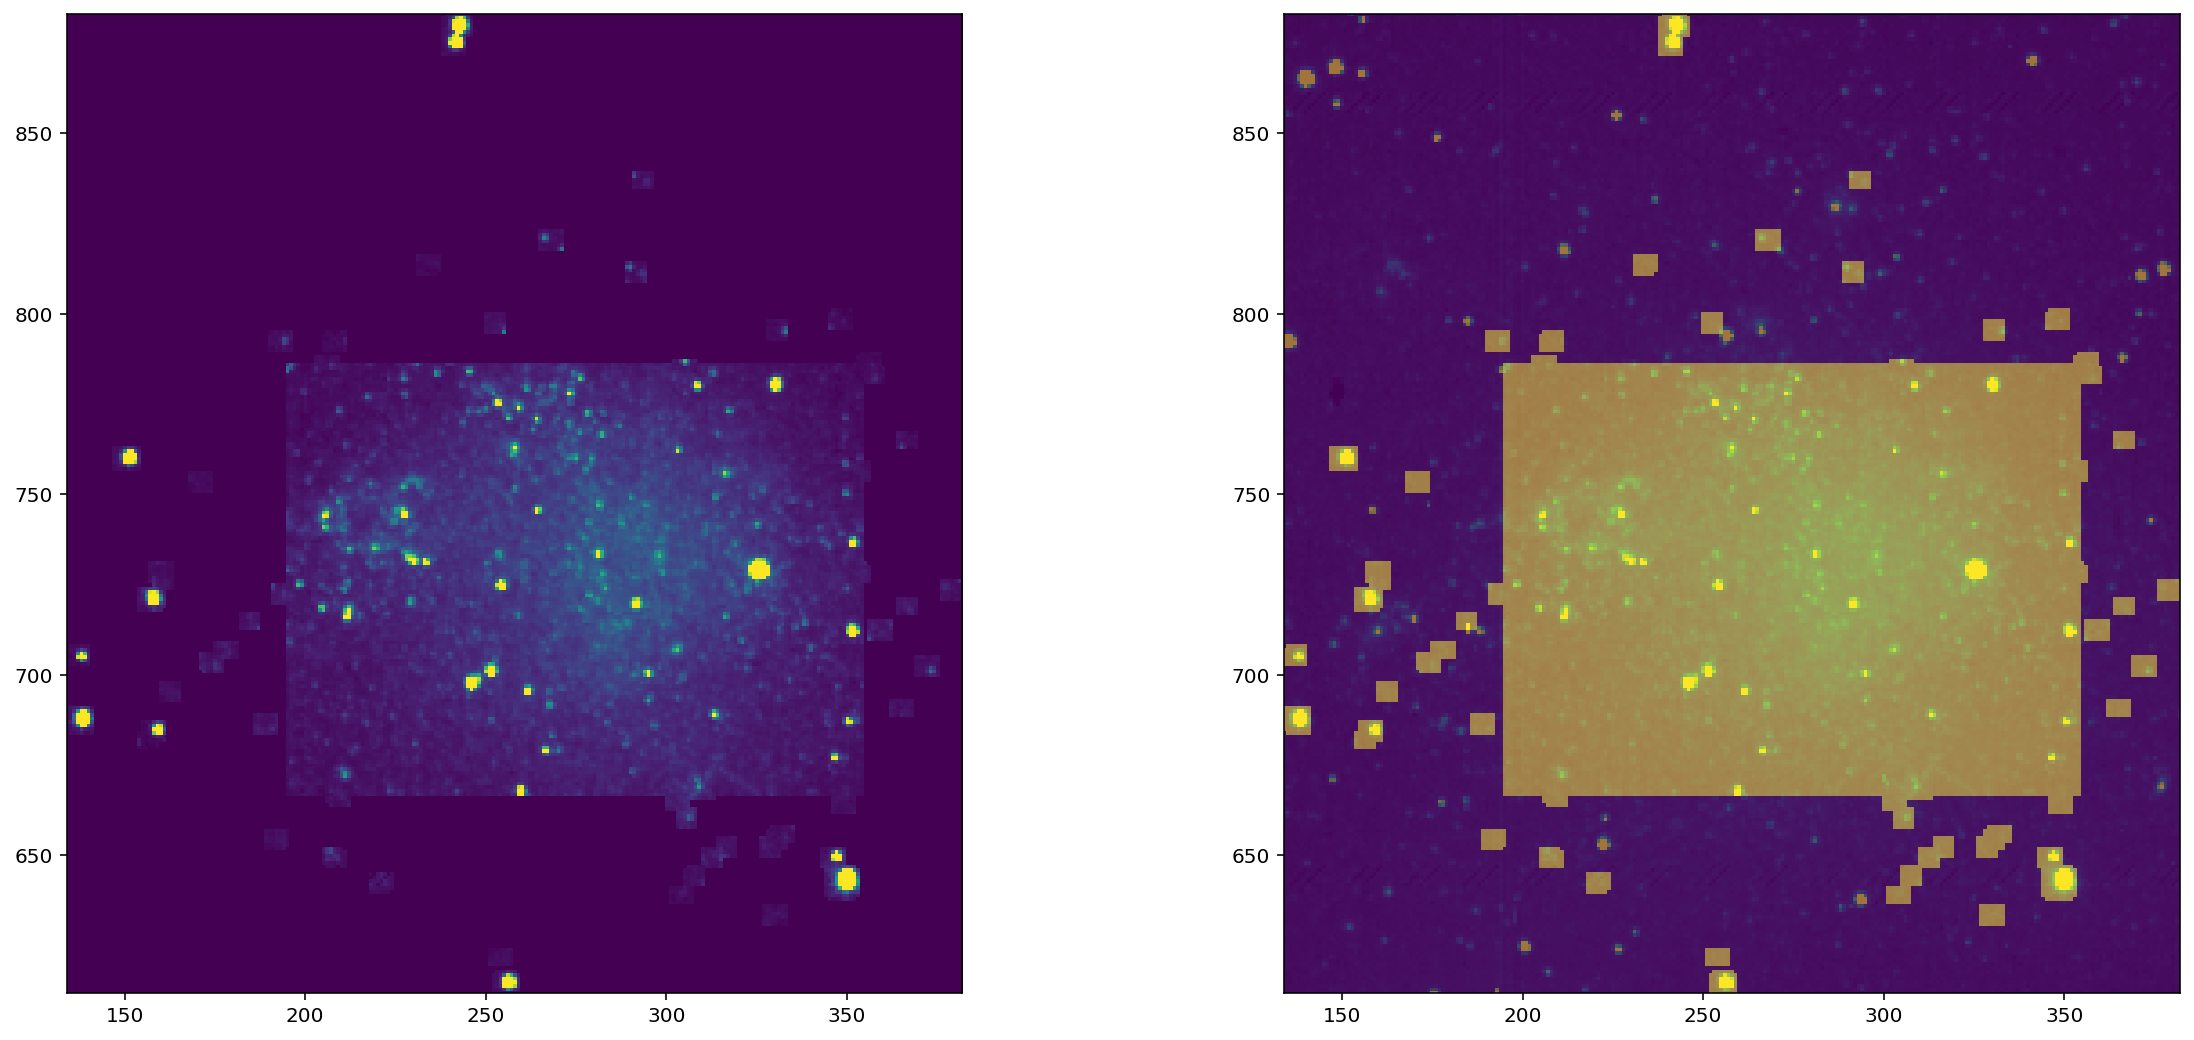

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(20,9))
axes[0].imshow(img.T, vmax=500, vmin=0, origin='lower');
axes[0].set_xlim(x_1D.min(), x_1D.max())
axes[0].set_ylim(y_1D.min(), y_1D.max())
axes[1].imshow(ffi_data, vmax=900, vmin=400, origin='lower');
axes[1].imshow(img.T!=0, origin='lower', alpha=0.5);
axes[1].set_xlim(x_1D.min(), x_1D.max())
axes[1].set_ylim(y_1D.min(), y_1D.max());

Checks out. :)

Call the background anything with a median-stacked value in the 9.5 percentile.

In [23]:
background_mask = z_vals < np.nanpercentile(z_vals, 9.5)

In [24]:
background_mask.sum()

2018

Nice! We have 2045 background pixels to analyze.

Let's plot these:

In [25]:
bkg_ts_1D = time_series_1D[:, background_mask]
bkg_x_1D = x_1D[background_mask]
bkg_y_1D = y_1D[background_mask]

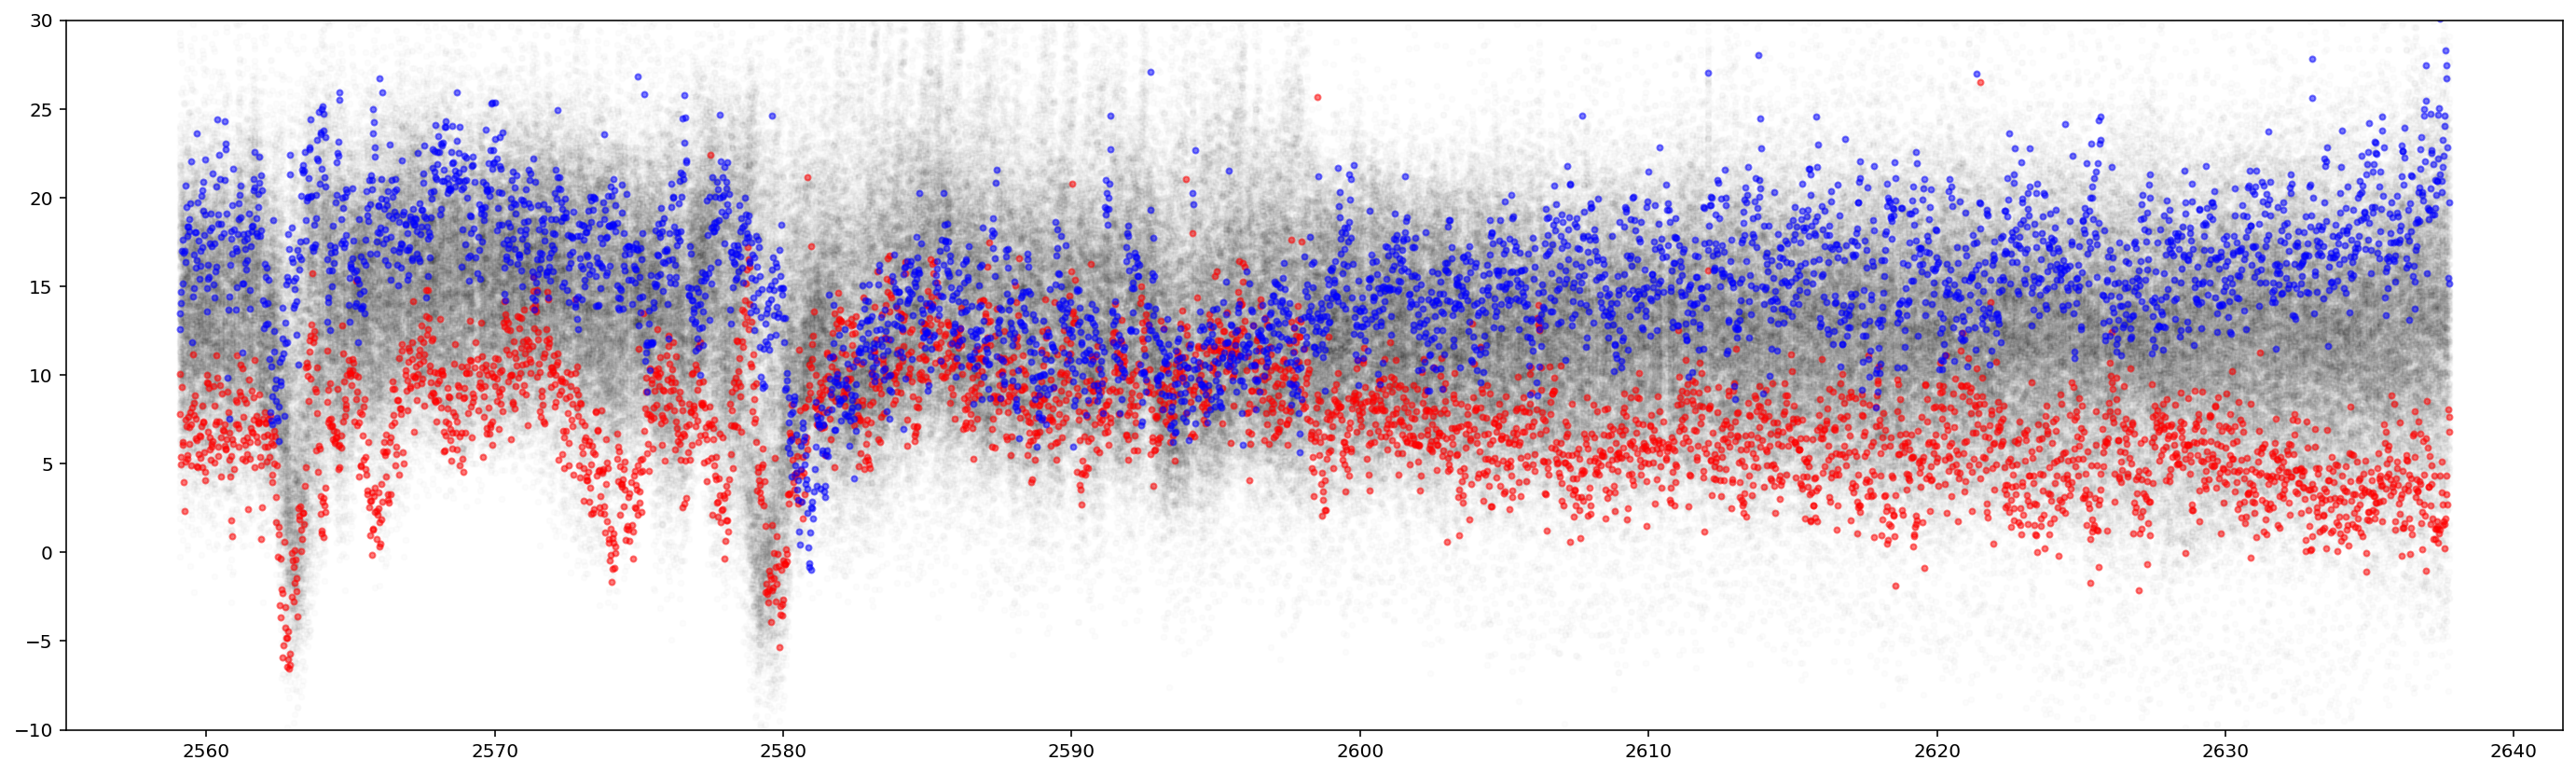

In [26]:
plt.figure(figsize=(24,7))
plt.plot(fixed_time, bkg_ts_1D[:, 0:100], 'k.', alpha=0.01);
plt.plot(fixed_time, bkg_ts_1D[:, 10], 'r.', alpha=0.5);
plt.plot(fixed_time, bkg_ts_1D[:, 90], 'b.', alpha=0.5);
plt.ylim(-10, 30);

It's a rolling band!

### Let's see which pixels correlate.

In [27]:
import seaborn as sns

In [28]:
sort_args = np.argsort(bkg_y_1D)

In [29]:
bkg_ts_1D.shape

(3595, 2018)

In [30]:
cor_coeff = np.corrcoef(bkg_ts_1D[:, sort_args].T)

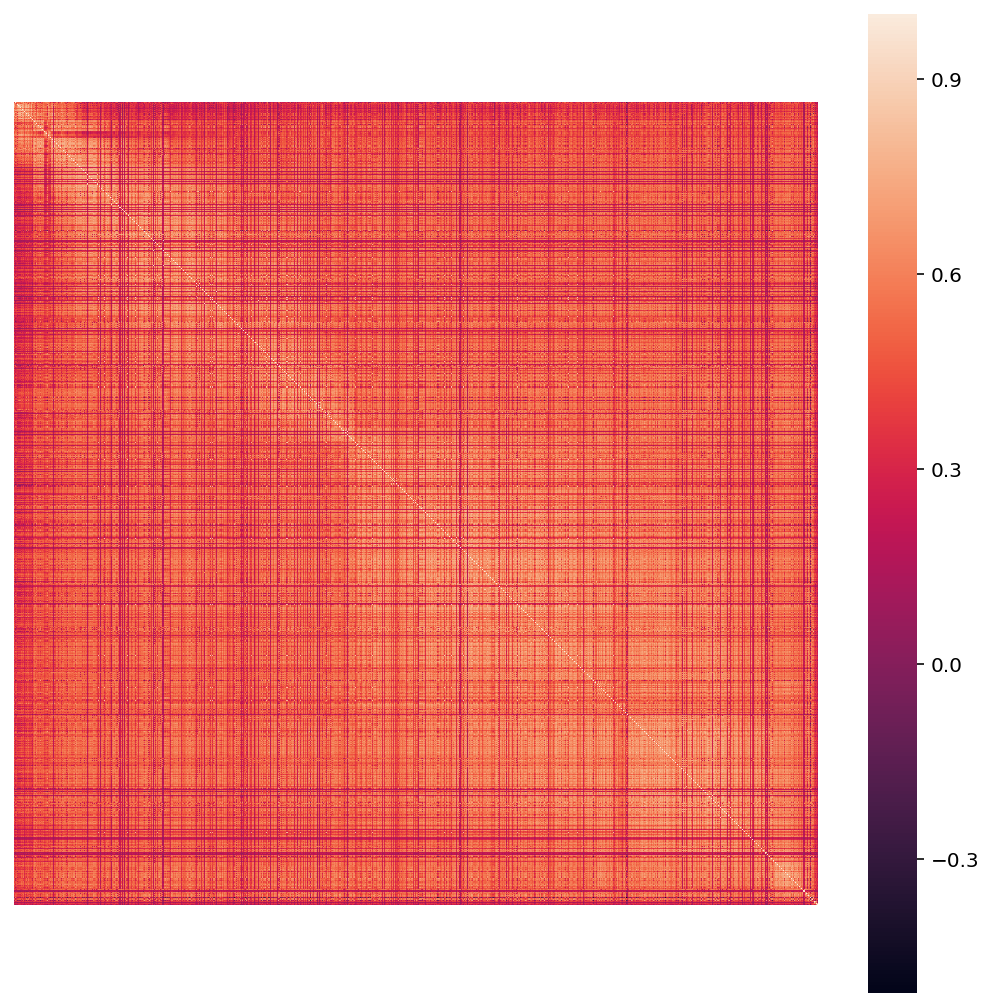

In [31]:
plt.figure(figsize=(9,9))
sns.heatmap(cor_coeff, square=True, xticklabels=False, yticklabels=False)

Weakly correlating structures!

In [32]:
import celerite
from celerite import terms

In [67]:
guess_rho = 2
guess_sigma = 6.2
guess_white_noise = 2.5
guess_log_sigma = np.log(guess_sigma)
guess_log_rho = np.log(guess_rho)  # Has units of time, so 1/f

In [83]:
kernel_matern = terms.Matern32Term(log_sigma=guess_log_sigma, log_rho=guess_log_rho, eps=0.000001)
kernel_matern_orig = terms.Matern32Term(log_sigma=guess_log_sigma, log_rho=guess_log_rho, eps=0.000001)

In [84]:
gp = celerite.GP(kernel_matern, mean=bkg_ts_1D.mean(), fit_mean=False)
gp_orig = celerite.GP(kernel_matern_orig, mean=bkg_ts_1D.mean(), fit_mean=False)

In [85]:
gp.compute(fixed_time, yerr=guess_white_noise)
gp_orig.compute(fixed_time, yerr=guess_white_noise)

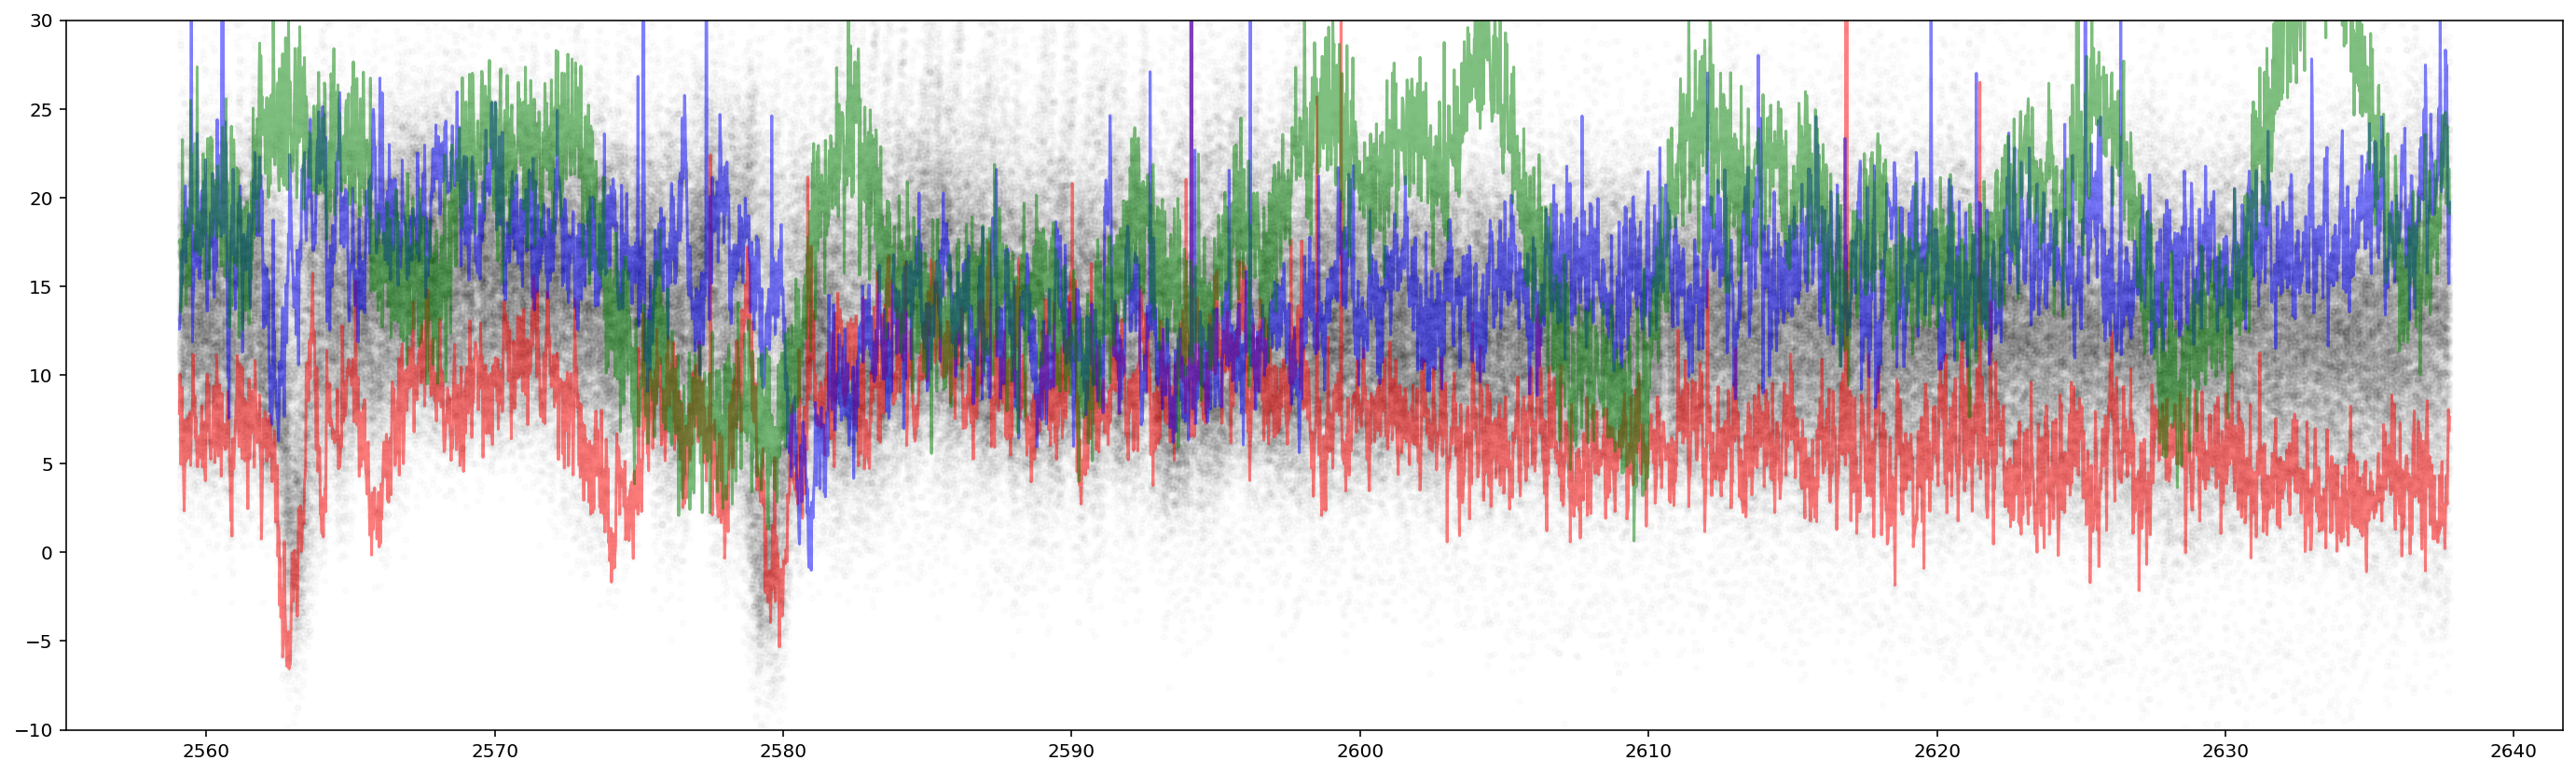

In [86]:
plt.figure(figsize=(24,7))
plt.plot(fixed_time, bkg_ts_1D[:, 0:100], 'k.', alpha=0.01);
plt.plot(fixed_time, bkg_ts_1D[:, 10], 'r-', alpha=0.5);
plt.plot(fixed_time, bkg_ts_1D[:, 90], 'b-', alpha=0.5);
plt.ylim(-10, 30);
plt.plot(fixed_time, gp_orig.sample(), 'g-', alpha=0.5);

Reasonable first guess!

In [87]:
print("Initial log-likelihood: {0}".format(gp.log_likelihood(bkg_ts_1D[:, 877])))

Initial log-likelihood: -11995.252342541804


### Conduct a *grid search* for $\rho$ and $\sigma$

In [154]:
rhos  = np.linspace(1, 5, 50)
sigmas = np.linspace(0.1, 20, 60)

In [155]:
n_pix = len(bkg_ts_1D[0, :])

In [156]:
likelihood_grid = np.zeros((50,60))
for i, rho in tqdm(enumerate(rhos), total=len(rhos)):
    for j, sigma in enumerate(sigmas):
        gp.set_parameter_vector(np.array([np.log(sigma), np.log(rho)]))
        for k in range(32):
            #likelihood_grid[i,j] += gp.log_likelihood(bkg_ts_1D[:, k])
            likelihood_grid[i,j] += gp.log_likelihood(gp_orig.sample())

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


In [157]:
extents = [sigmas.min(), sigmas.max(), rhos.min(), rhos.max()]

Text(0, 0.5, '$\\rho$ (days)')

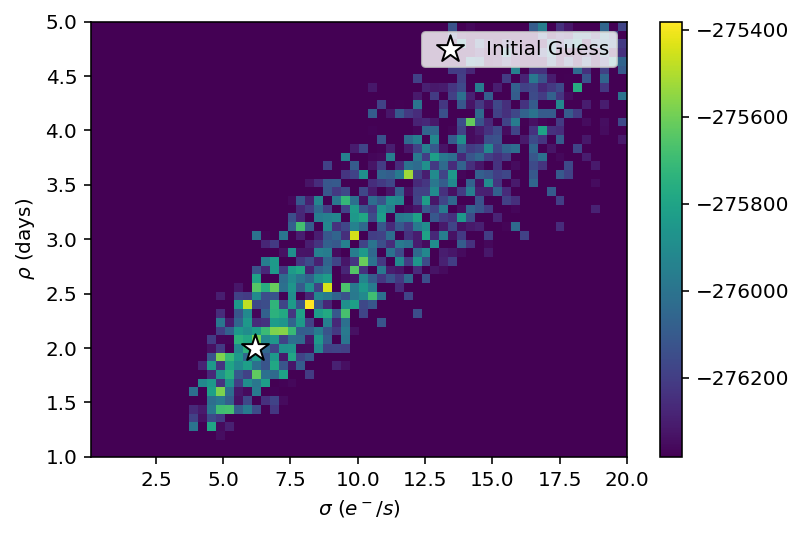

In [161]:
plt.imshow(likelihood_grid, origin='lower', extent=extents, 
           vmax=likelihood_grid.max(), 
           vmin=likelihood_grid.max()-1000,
           aspect='auto')
cb = plt.colorbar()
plt.scatter([guess_sigma], [guess_rho], color='w', marker='*', s=200, label='Initial Guess', ec='k')
plt.legend(loc='best')
plt.xlabel(r'$\sigma$ $(e^-/s)$')
plt.ylabel(r'$\rho$ (days)')

Neat!  It's a rugged terrain because of the approximate nature of the celerite matern kernel, and other factors.